In [9]:
import gymnasium as gym
import ale_py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Red simple (MLP) para CartPole
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 16),
            nn.ReLU(),
            nn.Linear(16, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Evalúa un individuo (sus parámetros) por promedio de episodios
def evaluate(params, state_dim, action_dim, episodes=3):
    env = gym.make('CartPole-v1')
    model = PolicyNet(state_dim, action_dim).to(device)
    model.load_state_dict(params)
    model.eval()

    total_reward = 0
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            state_tensor = torch.FloatTensor(obs).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = model(state_tensor)
            action = torch.argmax(logits).item()
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            obs = next_obs
            total_reward += reward
    env.close()
    return total_reward / episodes

# Cruzamiento (promedio de padres)
def crossover(p1, p2):
    child = {}
    for k in p1:
        child[k] = (p1[k] + p2[k]) / 2
    return child

# Mutación (ruido gaussiano)
def mutate(params, mutation_rate=0.1):
    for k in params:
        noise = torch.randn_like(params[k]) * mutation_rate
        params[k] += noise
    return params

# ==== CONFIGURACIÓN GA ====
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
env.close()

population_size = 20
generations = 40
mutation_rate = 0.02
elite_fraction = 0.2

# Inicializa la población con redes aleatorias
population = []
for _ in range(population_size):
    model = PolicyNet(state_dim, action_dim).to(device)
    population.append(model.state_dict())

best_scores = []





In [10]:
# ==== entrenamiento ====

for gen in range(generations):
    fitness = []
    for individual in population:
        score = evaluate(individual, state_dim, action_dim)
        fitness.append(score)

    sorted_indices = np.argsort(fitness)[::-1]
    elite_count = int(population_size * elite_fraction)
    next_population = [population[idx] for idx in sorted_indices[:elite_count]]

    print(f"Gen {gen + 1}, Best Fitness: {fitness[sorted_indices[0]]}")
    best_scores.append(fitness[sorted_indices[0]])

    while len(next_population) < population_size:
        parents = random.sample(next_population, 2)
        child = crossover(parents[0], parents[1])
        child = mutate(child, mutation_rate)
        next_population.append(child)

    population = next_population

Gen 1, Best Fitness: 51.666666666666664
Gen 2, Best Fitness: 227.33333333333334
Gen 3, Best Fitness: 77.33333333333333
Gen 4, Best Fitness: 235.0
Gen 5, Best Fitness: 254.33333333333334
Gen 6, Best Fitness: 261.6666666666667
Gen 7, Best Fitness: 500.0
Gen 8, Best Fitness: 227.33333333333334
Gen 9, Best Fitness: 354.3333333333333
Gen 10, Best Fitness: 268.6666666666667
Gen 11, Best Fitness: 231.33333333333334
Gen 12, Best Fitness: 226.66666666666666
Gen 13, Best Fitness: 374.0
Gen 14, Best Fitness: 500.0
Gen 15, Best Fitness: 500.0
Gen 16, Best Fitness: 376.6666666666667
Gen 17, Best Fitness: 387.0
Gen 18, Best Fitness: 370.6666666666667
Gen 19, Best Fitness: 405.6666666666667
Gen 20, Best Fitness: 500.0
Gen 21, Best Fitness: 372.3333333333333
Gen 22, Best Fitness: 380.6666666666667
Gen 23, Best Fitness: 500.0
Gen 24, Best Fitness: 500.0
Gen 25, Best Fitness: 380.0
Gen 26, Best Fitness: 419.6666666666667
Gen 27, Best Fitness: 500.0
Gen 28, Best Fitness: 374.0
Gen 29, Best Fitness: 500.0

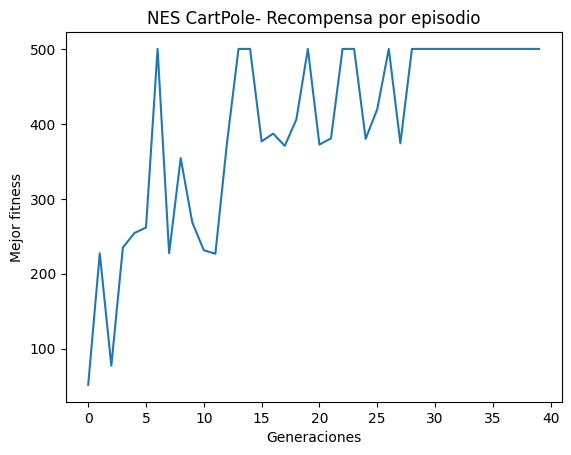

In [11]:
# ==== grafica ====

plt.plot(best_scores)
plt.xlabel('Generaciones')
plt.ylabel('Mejor fitness')
plt.title('NES CartPole- Recompensa por episodio')
plt.show()


In [14]:
# guardar el mejor individuo al final
best_index = np.argmax(fitness)
best_model = PolicyNet(state_dim, action_dim).to(device)
best_model.load_state_dict(population[best_index])
torch.save(best_model.state_dict(), "nes_cartpole.pth")
print("✅ Política guardada como 'nes_cartpole.pth'")


✅ Política guardada como 'nes_cartpole.pth'


In [15]:
# Para test o visualización
model = PolicyNet(state_dim, action_dim).to(device)
model.load_state_dict(torch.load("nes_cartpole.pth", map_location=device))
model.eval()


PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)